In [ ]:
# pip install CoolProp
!pip install tqdm

In [1]:
import pandas as pd
from CoolProp.CoolProp import PropsSI
from CoolProp.CoolProp import AbstractState
import CoolProp
import numpy as np
import math
from tqdm import tqdm
from tql.edos import *
from tql.utils import *
from tql.modelos import *
from tql.parametros_variables import *
from tql.propiedades import *
from scipy.integrate import solve_ivp

Tiempo (s): [ 0.          0.1010101   0.2020202   0.3030303   0.4040404   0.50505051
  0.60606061  0.70707071  0.80808081  0.90909091  1.01010101  1.11111111
  1.21212121  1.31313131  1.41414141  1.51515152  1.61616162  1.71717172
  1.81818182  1.91919192  2.02020202  2.12121212  2.22222222  2.32323232
  2.42424242  2.52525253  2.62626263  2.72727273  2.82828283  2.92929293
  3.03030303  3.13131313  3.23232323  3.33333333  3.43434343  3.53535354
  3.63636364  3.73737374  3.83838384  3.93939394  4.04040404  4.14141414
  4.24242424  4.34343434  4.44444444  4.54545455  4.64646465  4.74747475
  4.84848485  4.94949495  5.05050505  5.15151515  5.25252525  5.35353535
  5.45454545  5.55555556  5.65656566  5.75757576  5.85858586  5.95959596
  6.06060606  6.16161616  6.26262626  6.36363636  6.46464646  6.56565657
  6.66666667  6.76767677  6.86868687  6.96969697  7.07070707  7.17171717
  7.27272727  7.37373737  7.47474747  7.57575758  7.67676768  7.77777778
  7.87878788  7.97979798  8.08080808  8

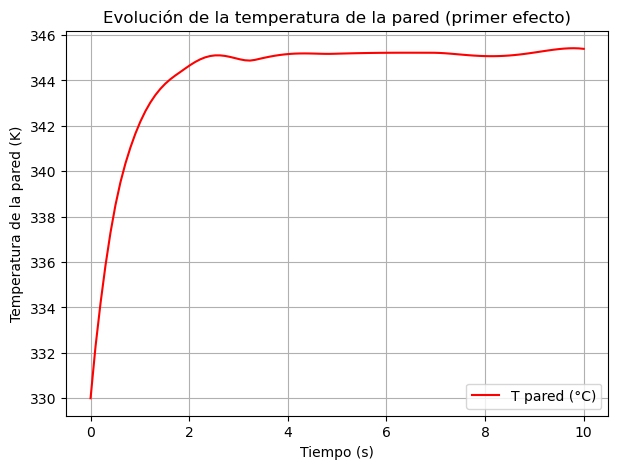

In [2]:
import matplotlib.pyplot as plt

if __name__ == "__main__":
    pastparams = Pastparams()
    effectparams_e1 = EvapEffectParams(pastparams, 1)  # Crear objeto para el primer efecto
    T0 = 330  # Se ajusta a un valor dentro del rango permitido
    t_final = 10
    sol = simular_temp_pared(T0, t_final, pastparams, effectparams_e1)
    print("Tiempo (s):", sol.t)
    print("Temperatura de la pared en el primer efecto (°C):", sol.y[0])

    # GRAFICAR RESULTADOS
    plt.figure(figsize=(7,5))
    plt.plot(sol.t, sol.y[0], label="T pared (°C)", color="red")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Temperatura de la pared (K)")
    plt.title("Evolución de la temperatura de la pared (primer efecto)")
    plt.grid(True)
    plt.legend()
    plt.show()


In [14]:
(4 * 0.33333333)/(PropsSI('V','T',353,'Q',1,'water')*3.14*0.95)
PropsSI('Prandtl','T',333,'Q',0.8,'water')

1.0285464528662966

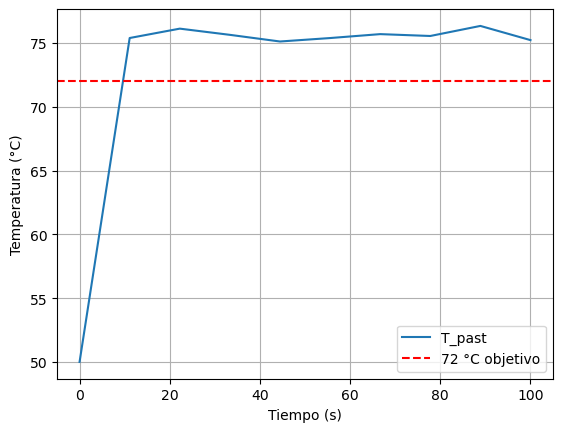

T_final = 75.23 °C


In [4]:
if __name__ == "__main__":
    # Ejemplo de uso / prueba
    # 1) Creamos el objeto de parámetros
    pparams = Pastparams()

    # 2) Simulamos
    t_span = (0, 100)    # 0 a 2000 s, por ejemplo
    T0 = 50.0             # arranca a 60°C
    sol = simulate_pasteurization(t_span, T0, pparams)
    
    # 3) Graficamos
    t_eval = np.linspace(t_span[0], t_span[1], 10)
    Tpast_sol = sol.sol(t_eval)[0]  # hay solo 1 estado
    import matplotlib.pyplot as plt
    plt.plot(t_eval, Tpast_sol, label='T_past')
    plt.axhline(72, color='r', linestyle='--', label='72 °C objetivo')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Temperatura (°C)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 4) Imprimimos valor final
    print(f"T_final = {Tpast_sol[-1]:.2f} °C")

In [ ]:
def ent_latent_cond(Ts, Tw):

    Tw = np.array(Tw) # Convertir a array si no lo es
    T_prom = (Ts + Tw) / 2

    # Evaluar PropsSI solo en valores escalares

    h_l = PropsSI('H', 'T', Ts, 'Q', 0, 'water')
    h_v = PropsSI('H', 'T', Ts, 'Q', 1, 'water')
    h_lv_corr = (h_v - h_l) + (0.68 * cp_agua * (Ts - Tw))

    # Validar h_lv_corr
    if np.isnan(h_lv_corr) or h_lv_corr <= 0:
        print(f"Advertencia: h_lv_corr inválido ({h_lv_corr}). Ajustando...")
        h_lv_corr = 1e3  # Valor seguro

    return h_lv_corr

In [7]:
ent_latent_cond(353,343)

2336896.354270024

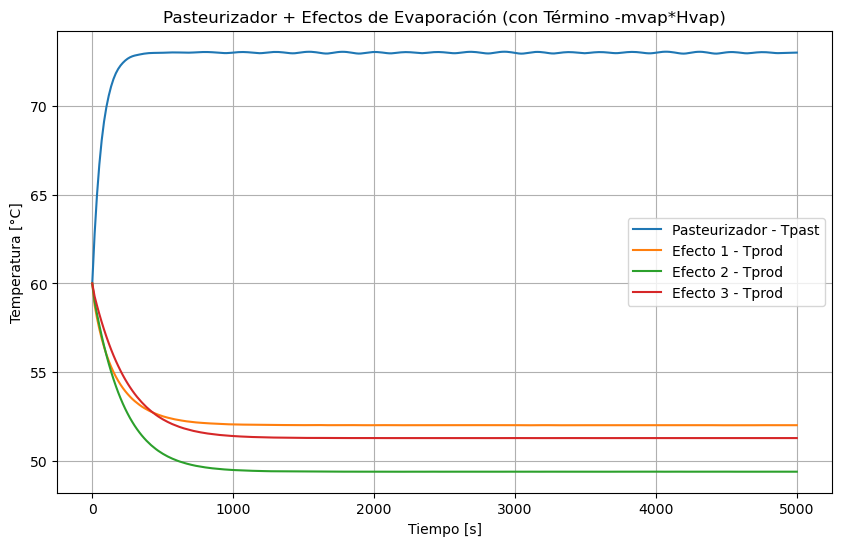

T final en el último efecto: 51.27 °C


In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


##################################################
# 1) PASTEURIZADOR
##################################################
def pasteurization_ode(t, y, params):
    """
    EDO del pasteurizador:
    dTpast/dt = [ m_suero*cp_suero*(T_in - Tpast)
                  + U*A*(T_vapor - Tpast) ]
                / ( m_hold * cp_suero )
    y = [Tpast]
    """
    Tpast = y[0]

    # Parámetros
    m_suero = params["m_suero"]  # kg/s (flujo)
    cp_suero = params["cp_suero"]  # J/(kg*K)
    m_hold = params["m_hold"]  # kg en el pasteurizador
    U = params["U"]  # W/(m2*K)
    A = params["A"]  # m2
    T_in = params["T_in"]  # °C
    T_vapor = params["T_vapor"]  # °C

    # Balance de energía
    Q_suero = m_suero * cp_suero * (T_in - Tpast)
    Q_vapor = U * A * (T_vapor - Tpast)

    dTpast_dt = (Q_suero + Q_vapor) / (m_hold * cp_suero)
    return [dTpast_dt]


def simulate_pasteurization(t_span, T0, params):
    """
    Resuelve la ODE del pasteurizador en [t_span].
    - T0: temperatura inicial (°C)
    - params: diccionario con parámetros
    Retorna 'sol' con 'sol.t', 'sol.y', y 'sol.sol' (dense_output).
    """
    sol = solve_ivp(
        fun=pasteurization_ode,
        t_span=t_span,
        y0=[T0],
        args=(params,),
        dense_output=True,
    )
    return sol


##################################################
# 2) EVAPORADOR
##################################################
def evaporator_effect_ode_evap(t, y, params, T_in_func):
    """
    Modelo dinámico p/con evaporación (masa fija en el efecto).
    y = [T_wall, T_prod]

    Ecuaciones:

    (a) Pared:
       m_wall*cp_wall * dT_wall/dt
         = h_out*A*(T_steam - T_wall)
           - h_in*A*(T_wall - T_prod)

    (b) Producto:
       m_prod*cp_prod * dT_prod/dt
         = dotm_in*cp_prod*(T_in - T_prod)
           + h_in*A*(T_wall - T_prod)
           - mvap*Hvap

    donde mvap = params["mvap"] (asumida cte) o la calculas según tu modelo.
    """
    T_wall, T_prod = y

    # Extraemos parámetros
    m_wall = params["m_wall"]
    cp_wall = params["cp_wall"]
    m_prod = params["m_prod"]
    cp_prod = params["cp_prod"]
    dotm_in = params["dotm_in"]  # kg/s (alimentación)
    h_in = params["h_in"]
    h_out = params["h_out"]
    A = params["A"]
    T_steam = params["T_steam"]  # Vapor cond.
    Hvap = params["Hvap"]  # J/kg (calor latente)
    mvap = params["mvap"]  # kg/s (flujo evaporado, sup. cte)

    # T_in(t) => temperatura de entrada del producto en tiempo t
    T_in = T_in_func(t)

    # EDO (a) Pared
    dT_wall_dt = (h_out * A * (T_steam - T_wall) - h_in * A * (T_wall - T_prod)) / (
        m_wall * cp_wall
    )

    # EDO (b) Producto (con evaporación)
    dT_prod_dt = (
        dotm_in * cp_prod * (T_in - T_prod)
        + h_in * A * (T_wall - T_prod)
        - mvap * Hvap  # <-- Término de evaporación
    ) / (m_prod * cp_prod)

    return [dT_wall_dt, dT_prod_dt]


def simulate_evaporator_effect_evap(t_span, y0, params, T_in_func):
    """
    Resuelve el efecto de evaporación (con evaporación) en [t_span].
    y0 = [T_wall0, T_prod0]
    T_in_func(t) => da la T de alimentación en cada instante.

    Retorna 'sol' con dense_output.
    """
    sol = solve_ivp(
        fun=lambda t, y: evaporator_effect_ode_evap(t, y, params, T_in_func),
        t_span=t_span,
        y0=y0,
        dense_output=True,
    )
    return sol


##################################################
# 3) FUNCIÓN PRINCIPAL: PASTEURIZADOR + N EFECTOS
##################################################
def main_simulation():
    # --- PARÁMETROS DE TIEMPO ---
    t_span = (0, 5000)  # simulamos 0 a 5000 s

    # ----------------------------------------------------------------
    # 1) Simulación del Pasteurizador
    # ----------------------------------------------------------------
    pasteur_params = {
        "m_suero": 1.0,  # kg/s
        "cp_suero": 4000.0,  # J/(kg*K)
        "m_hold": 200.0,  # kg
        "U": 1500.0,  # W/(m2*K)
        "A": 5.0,  # m2
        "T_in": 60.0,  # °C (suero entra a 60°C)
        "T_vapor": 80.0,  # °C
    }
    T0_pasteur = 60.0
    sol_past = simulate_pasteurization(t_span, T0_pasteur, pasteur_params)

    # Función que devuelve T_past(t) desde la solución del pasteurizador
    def T_past_func(t):
        return sol_past.sol(t)[0]  # T_past(t) es la única variable

    # ----------------------------------------------------------------
    # 2) Definimos N efectos de evaporación
    #    (cada uno con sus parámetros, p.ej. en una lista)
    # ----------------------------------------------------------------
    N_efectos = 3

    # Creamos una lista de diccionarios, uno por cada efecto:
    efectos_params = [
        # Efecto 1
        {
            "m_wall": 500.0,  # kg
            "cp_wall": 500.0,
            "m_prod": 800.0,  # kg
            "cp_prod": 3800.0,
            "dotm_in": 1.0,  # kg/s
            "h_in": 1000.0,
            "h_out": 3000.0,
            "A": 15.0,
            "T_steam": 85.0,  # °C (vapor cond. en 1er efecto)
            "Hvap": 2.256e6,  # J/kg
            "mvap": 0.2,  # kg/s evaporado (p.ej. cte)
        },
        # Efecto 2
        {
            "m_wall": 400.0,
            "cp_wall": 500.0,
            "m_prod": 700.0,
            "cp_prod": 3800.0,
            "dotm_in": 1.0,
            "h_in": 1200.0,
            "h_out": 3500.0,
            "A": 12.0,
            "T_steam": 80.0,  # °C
            "Hvap": 2.256e6,
            "mvap": 0.15,  # kg/s evaporado
        },
        # Efecto 3
        {
            "m_wall": 300.0,
            "cp_wall": 500.0,
            "m_prod": 600.0,
            "cp_prod": 3800.0,
            "dotm_in": 1.0,
            "h_in": 1300.0,
            "h_out": 4000.0,
            "A": 10.0,
            "T_steam": 75.0,
            "Hvap": 2.256e6,
            "mvap": 0.1,
        },
    ]

    # Estados iniciales (T_wall, T_prod) para cada efecto
    Twall0 = 60.0
    Tprod0 = 60.0

    # Almacenar las soluciones en una lista
    soluciones_efectos = []

    # La salida del pasteurizador alimenta al 1er efecto:
    T_in_func_efecto = T_past_func  # arranque

    # Iteramos sobre cada efecto
    for i in range(N_efectos):
        params_ef = efectos_params[i]
        # Simulamos en [t_span] con y0
        y0_ef = [Twall0, Tprod0]
        sol_ef = simulate_evaporator_effect_evap(
            t_span=t_span, y0=y0_ef, params=params_ef, T_in_func=T_in_func_efecto
        )
        soluciones_efectos.append(sol_ef)

        # La temperatura de salida del efecto i
        # => Tprod(t) = sol_ef.sol(t)[1]
        def make_input_func(sol):
            return lambda tau: sol.sol(tau)[1]

        # La entrada al siguiente efecto = salida Tprod de este
        T_in_func_efecto = make_input_func(sol_ef)

    # ----------------------------------------------------------------
    # 3) Graficar resultados
    # ----------------------------------------------------------------
    t_eval = np.linspace(t_span[0], t_span[1], 300)

    # 3.1) Grafico la temperatura del pasteurizador
    Tpast_arr = sol_past.sol(t_eval)[0]
    plt.figure(figsize=(10, 6))
    plt.plot(t_eval, Tpast_arr, label="Pasteurizador - Tpast")

    # 3.2) Grafico la evolución de T_prod en cada efecto
    for i, sol_ef in enumerate(soluciones_efectos, start=1):
        Twall_vals = sol_ef.sol(t_eval)[0]
        Tprod_vals = sol_ef.sol(t_eval)[1]
        plt.plot(t_eval, Tprod_vals, label=f"Efecto {i} - Tprod")
        # (Opcional) también podrías graficar Twall_vals si quieres

    plt.xlabel("Tiempo [s]")
    plt.ylabel("Temperatura [°C]")
    plt.title("Pasteurizador + Efectos de Evaporación (con Término -mvap*Hvap)")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Ejemplo: muestro la T final en el último efecto
    Tprod_final_ultimo = soluciones_efectos[-1].sol(t_eval[-1])[1]
    print(f"T final en el último efecto: {Tprod_final_ultimo:.2f} °C")


if __name__ == "__main__":
    main_simulation()


=== Parámetros sorteados ===
T_in       = 56.82 °C
T_vapor    = 81.43 °C
alpha      = 1.00
m_suero    = 5.69 kg/s
cp_suero    = 3909.74 j/kgK
Solución de la EDO: OK


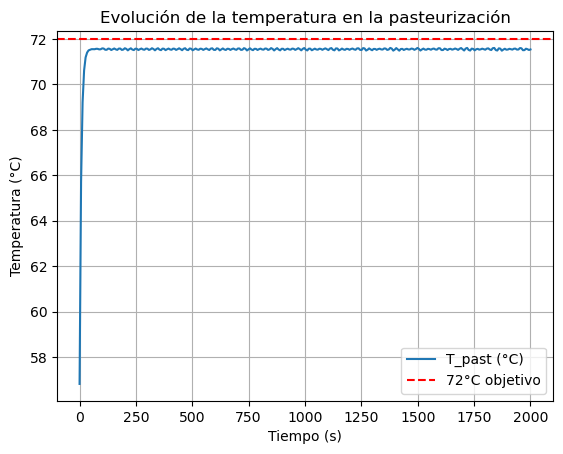

In [8]:
simulate_pasteurization()

In [3]:
KPI_evap(4,4000)

NameError: name 'cp_suero' is not defined